In [1]:
%reset -f
import ROOT, numpy
ROOT.gStyle.SetTitleOffset(1.3,'y')


fname = "../data/lvl2_eppi0.inb.mc.root"

conf = 'inb.qa' if 'inb' in fname else 'outb.qa'

rdf = ROOT.RDataFrame("h22", fname)
rdf = rdf.Define("pe","sqrt(ex*ex+ey*ey+ez*ez)")
rdf = rdf.Define("pp","sqrt(px*px+py*py+pz*pz)")

ecorrfile = '../code/utsav.inb.code' if 'inb' in fname else '../code/utsav.outb.code'
with open(ecorrfile) as ff:
    corrcode = ff.read()

rdf = rdf.Range(100000)
rdf = rdf.Define("fe", corrcode+"return fe;")

rdf = rdf.Define("vals","""
auto beam = ROOT::Math::PxPyPzMVector(0,0,10.6041,0);
auto targ = ROOT::Math::PxPyPzMVector(0,0,0,0.938);
auto ele = ROOT::Math::PxPyPzMVector(ex,ey,ez,0);
auto pro = ROOT::Math::PxPyPzMVector(px,py,pz,0.938);

auto epx = beam+targ-ele-pro;
epx.M2() == (0.135^2)


float th = pro.Theta()*TMath::RadToDeg();
float p0 = pro.P();
float p1 = p0;
if(th>27) p1 += TMath::Exp(-1.2 -4.212*p0) + 0.007575;
float fp = p1/p0;

auto pro1= ROOT::Math::PxPyPzMVector(px*fp,py*fp,pz*fp, 0.938);
auto ele2 = ROOT::Math::PxPyPzMVector(fe*ex,fe*ey,fe*ez,0);

auto epx0 = beam+targ-ele-pro;
auto epx1 = beam+targ-ele-pro1;
auto epx2 = beam+targ-ele2-pro;
auto epx3 = beam+targ-ele2-pro1;

auto qq = beam-ele;
auto ww = beam+targ-ele;

std::vector<double> vals = {epx0.M2(), epx1.M2(), pro1.Px(), pro1.Py(), pro1.Pz(), -qq.M2(), ww.M(), epx2.M2(), epx3.M2()};
return vals;
""")

#outdf = rdf.Define("prox","(float) vals[2]")
#outdf = outdf.Define("proy","(float) vals[3]")
#outdf = outdf.Define("proz","(float) vals[4]")
#outdf.Snapshot("h22", "lvl2_eppi0.inb.4corr.root", ("ex","ey","ez","esec","prox","proy","proz","psec"))
#outdf.Snapshot("h22", "lvl2_eppi0.inb.4corr.root", tuple("ex,ey,ez,esec,prox,proy,proz,psec".split(",")))


rdf = rdf.Define('mm0', 'vals[0]')
rdf = rdf.Define('mm1', 'vals[1]')
rdf = rdf.Define('mm2', 'vals[7]')
rdf = rdf.Define('mm3', 'vals[8]')
rdf = rdf.Define('Q2', 'vals[5]')
rdf = rdf.Define('W', 'vals[6]')

rdf = rdf.Filter("Q2>2 && W>2")

rdf = rdf.Define("pth","atan2(sqrt(px*px+py*py), pz)*TMath::RadToDeg()")

lbl = 'MC' if 'mc' in conf else 'DATA'
hpth = rdf.Histo2D(("hpth",f"polar angle vs momentum coverage for proton in {lbl};momentum;#theta [#circ]",200,0,4,200,0,50),"pp","pth")
hpepp = rdf.Histo2D(("hpepp","pe vs pp;electron;proton",200,0,9,200,0,4),"pe","pp")

hmm0 = rdf.Histo1D(("hmm0","MM^{2}_{epX};MM^{2}_{epX}",200,-0.5,0.5),'mm0')
hmm1 = rdf.Histo1D(("hmm1","MM^{2}_{epX};MM^{2}_{epX}",200,-0.5,0.5),'mm1')
hmm2 = rdf.Histo1D(("hmm2","MM^{2}_{epX};MM^{2}_{epX}",200,-0.5,0.5),'mm2')
hmm3 = rdf.Histo1D(("hmm3","MM^{2}_{epX};MM^{2}_{epX}",200,-0.5,0.5),'mm3')

hmm0pp = rdf.Histo2D(("hmm0pp","before correction;proton momentum [GeV];MM^{2}_{epX}",100,0,3,200,-0.5,0.5),"pp","mm0")
hmm1pp = rdf.Histo2D(("hmm1pp","after correction;proton momentum [GeV];MM^{2}_{epX}",100,0,3,200,-0.5,0.5),"pp","mm1")

hmm0pe = rdf.Histo2D(("hmm0pe","before correction;electron momentum [GeV];MM^{2}_{epX}",100,0,10,200,-0.5,0.5),"pe","mm0")
hmm2pe = rdf.Histo2D(("hmm2pe","after e correction;electron momentum [GeV];MM^{2}_{epX}",100,0,10,200,-0.5,0.5),"pe","mm2")
hmm3pe = rdf.Histo2D(("hmm3pe","after e correction + energy loss;electron momentum [GeV];MM^{2}_{epX}",100,0,10,200,-0.5,0.5),"pe","mm3")



hmm1pps = [rdf.Filter(f"psec=={psec}").Histo2D(("hmm1pp","after correction;proton momentum [GeV];MM^{2}_{epX}",100,0,3,200,-0.5,0.5),"pp","mm1") for psec in range(1,7)]

def fit2d(h2):
    xmin = 0.55 if 'outb' in conf else 0.4
    xlims = numpy.concatenate((numpy.arange(xmin, 1.5, 0.15), numpy.arange(1.5, 3.1, 0.3)))
    if 'pe' in h2.GetName():
        xlims = [2,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8]
    gx = h2.ProjectionX().Clone("h2x")
    hys = []
    gr = ROOT.TGraphErrors()
    #gr.SetMarkerSize(2)
    gr.SetMarkerStyle(20)
    for x1,x2 in zip(xlims[:-1], xlims[1:]):
        ib1,ib2 = gx.FindBin(x1), gx.FindBin(x2)
        gx.GetXaxis().SetRange(ib1, ib2)
        xmean = gx.GetMean()
        hy = h2.ProjectionY(f"hy{ib1}",ib1,ib2)
        hy.SetDirectory(0)
        hys.append(hy)
        mx = hy.GetBinCenter(hy.GetMaximumBin())
        fy = ROOT.TF1("fy","gaus(0)+pol1(3)",mx-0.3,mx+0.3)
        fy.SetParameters(2000,mx,0.05,1,1)
        fy.SetParLimits(1,0,1)
        fy.SetParLimits(2,0,0.1)
        #fy.SetParLimits(1,mx-0.2,mx+0.2)
        #fy.SetParLimits(2,0.005,0.02)
        hy.Fit(fy,"QR")
        mu,sig = fy.GetParameter(1),abs(fy.GetParameter(2))
        fy.SetRange(mu-2*sig, mu+2*sig)
        hy.Fit(fy,"QR")
        hy.SetTitle("{:.2f}<p<{:.2f}".format(x1,x2))
        gr.SetPoint(gr.GetN(), xmean, fy.GetParameter(1))
        gr.SetPointError(gr.GetN()-1, 0, fy.GetParError(1))
    setattr(h2,"hys",hys)
    setattr(h2,"gr",gr)


fit2d(hmm0pp)
fit2d(hmm1pp)
[fit2d(h1) for h1 in hmm1pps]

fit2d(hmm0pe)
fit2d(hmm2pe)
fit2d(hmm3pe)


Welcome to JupyROOT 6.24/06


Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 


In [2]:
c1 = ROOT.TCanvas("c1","c1",1100,800)
c1.SetGrid()
ROOT.gStyle.SetAxisColor(16,'xy')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


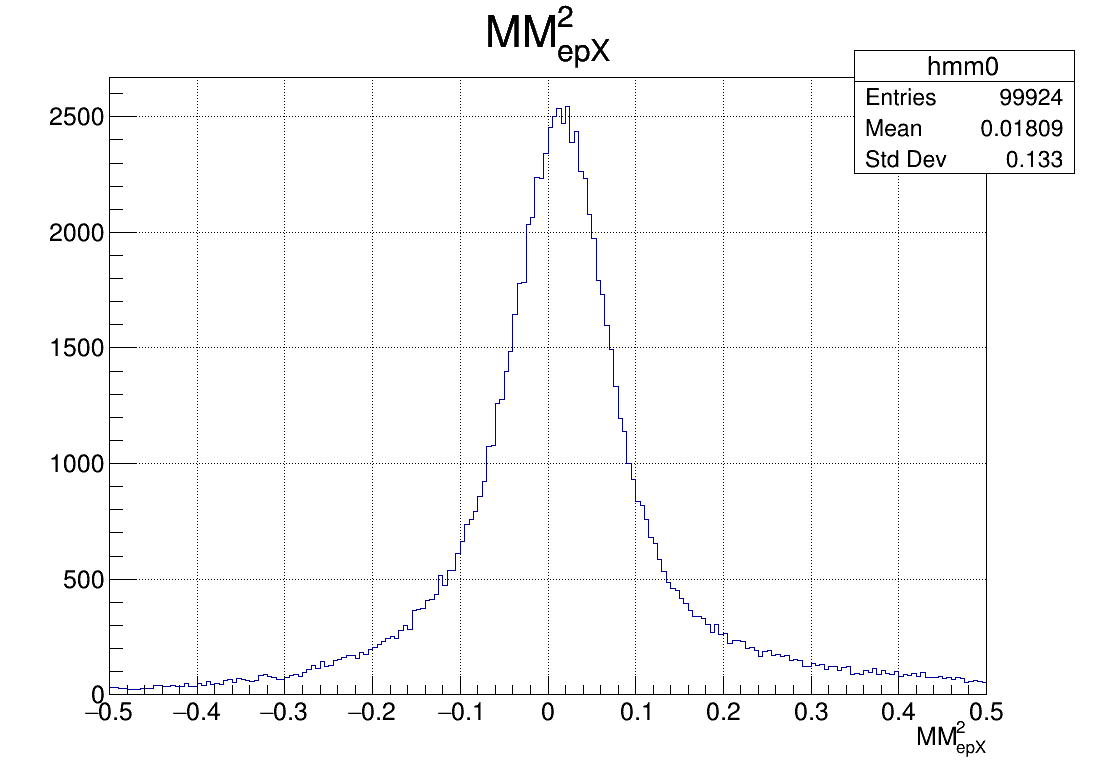

In [3]:
c1.Draw()
hmm0.Draw()
#hmm1.Draw()
#hmm1.SetLineColor(2)
#hmm0.Draw('same')
#hmm2.Draw('same')
#hmm3.Draw('same')

In [4]:
#c1.Draw()
ROOT.gStyle.SetOptStat(0)
hpth.Draw("colz")

In [5]:
#c1.Draw()
hpepp.Draw("colz")

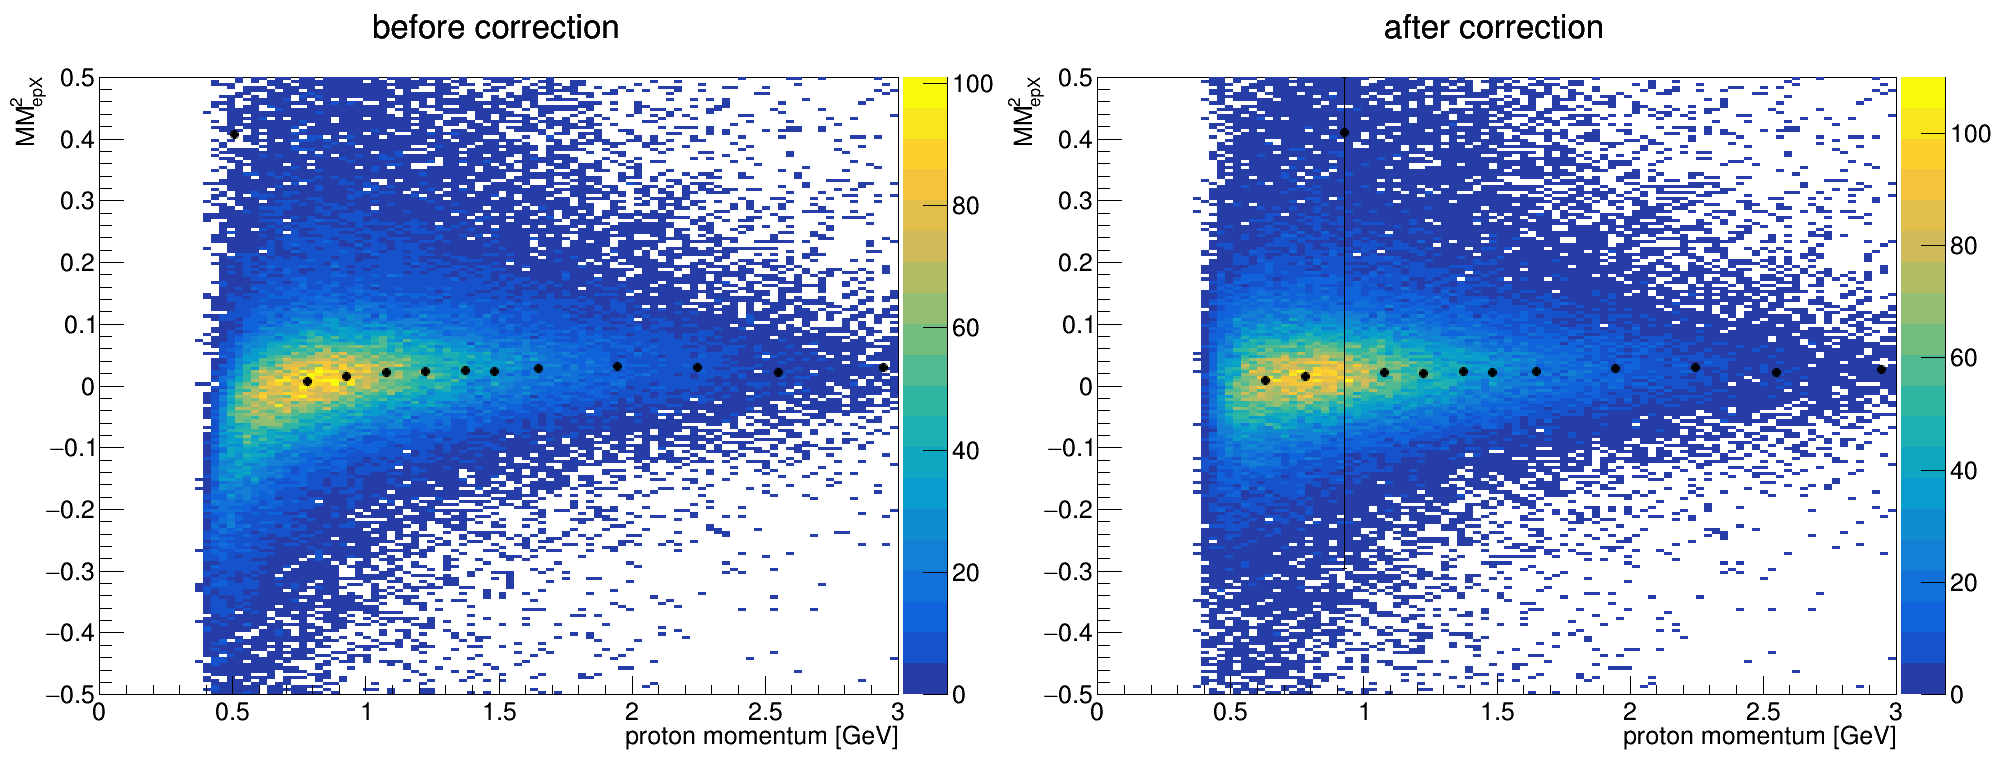

In [6]:
c2 = ROOT.TCanvas("c2","c2",2000,800)
c2.Divide(2,1,0.0001,0.0001)
c2.Draw()
ROOT.gStyle.SetOptStat(0)
c2.cd(1)
hmm0pp.Draw("colz")
hmm0pp.gr.Draw("P")
c2.cd(2)
hmm1pp.Draw("colz")
hmm1pp.gr.Draw("P")


In [7]:
c1 = ROOT.TCanvas("c1","c1",1100,800)
c1.SetGrid()
#c1.Draw()
hpad = c1.DrawFrame(0,-0.15,3,0.055)
hmm0pp.gr.Draw("P")
hmm1pp.gr.SetMarkerColor(2)
hmm1pp.gr.Draw("P")
hpad.SetTitle("before and after energy loss correction;proton momentum [GeV];MM^{2}_{epX}")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


_________________________

In [8]:
c2 = ROOT.TCanvas("c2","c2",2000,800)
c2.Divide(2,1,0.0001,0.0001)
#c2.Draw()
ROOT.gStyle.SetOptStat(0)
c2.cd(1)
hmm0pe.Draw("colz")
hmm0pe.gr.Draw("P")
c2.cd(2)
hmm2pe.Draw("colz")
hmm2pe.gr.Draw("P")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


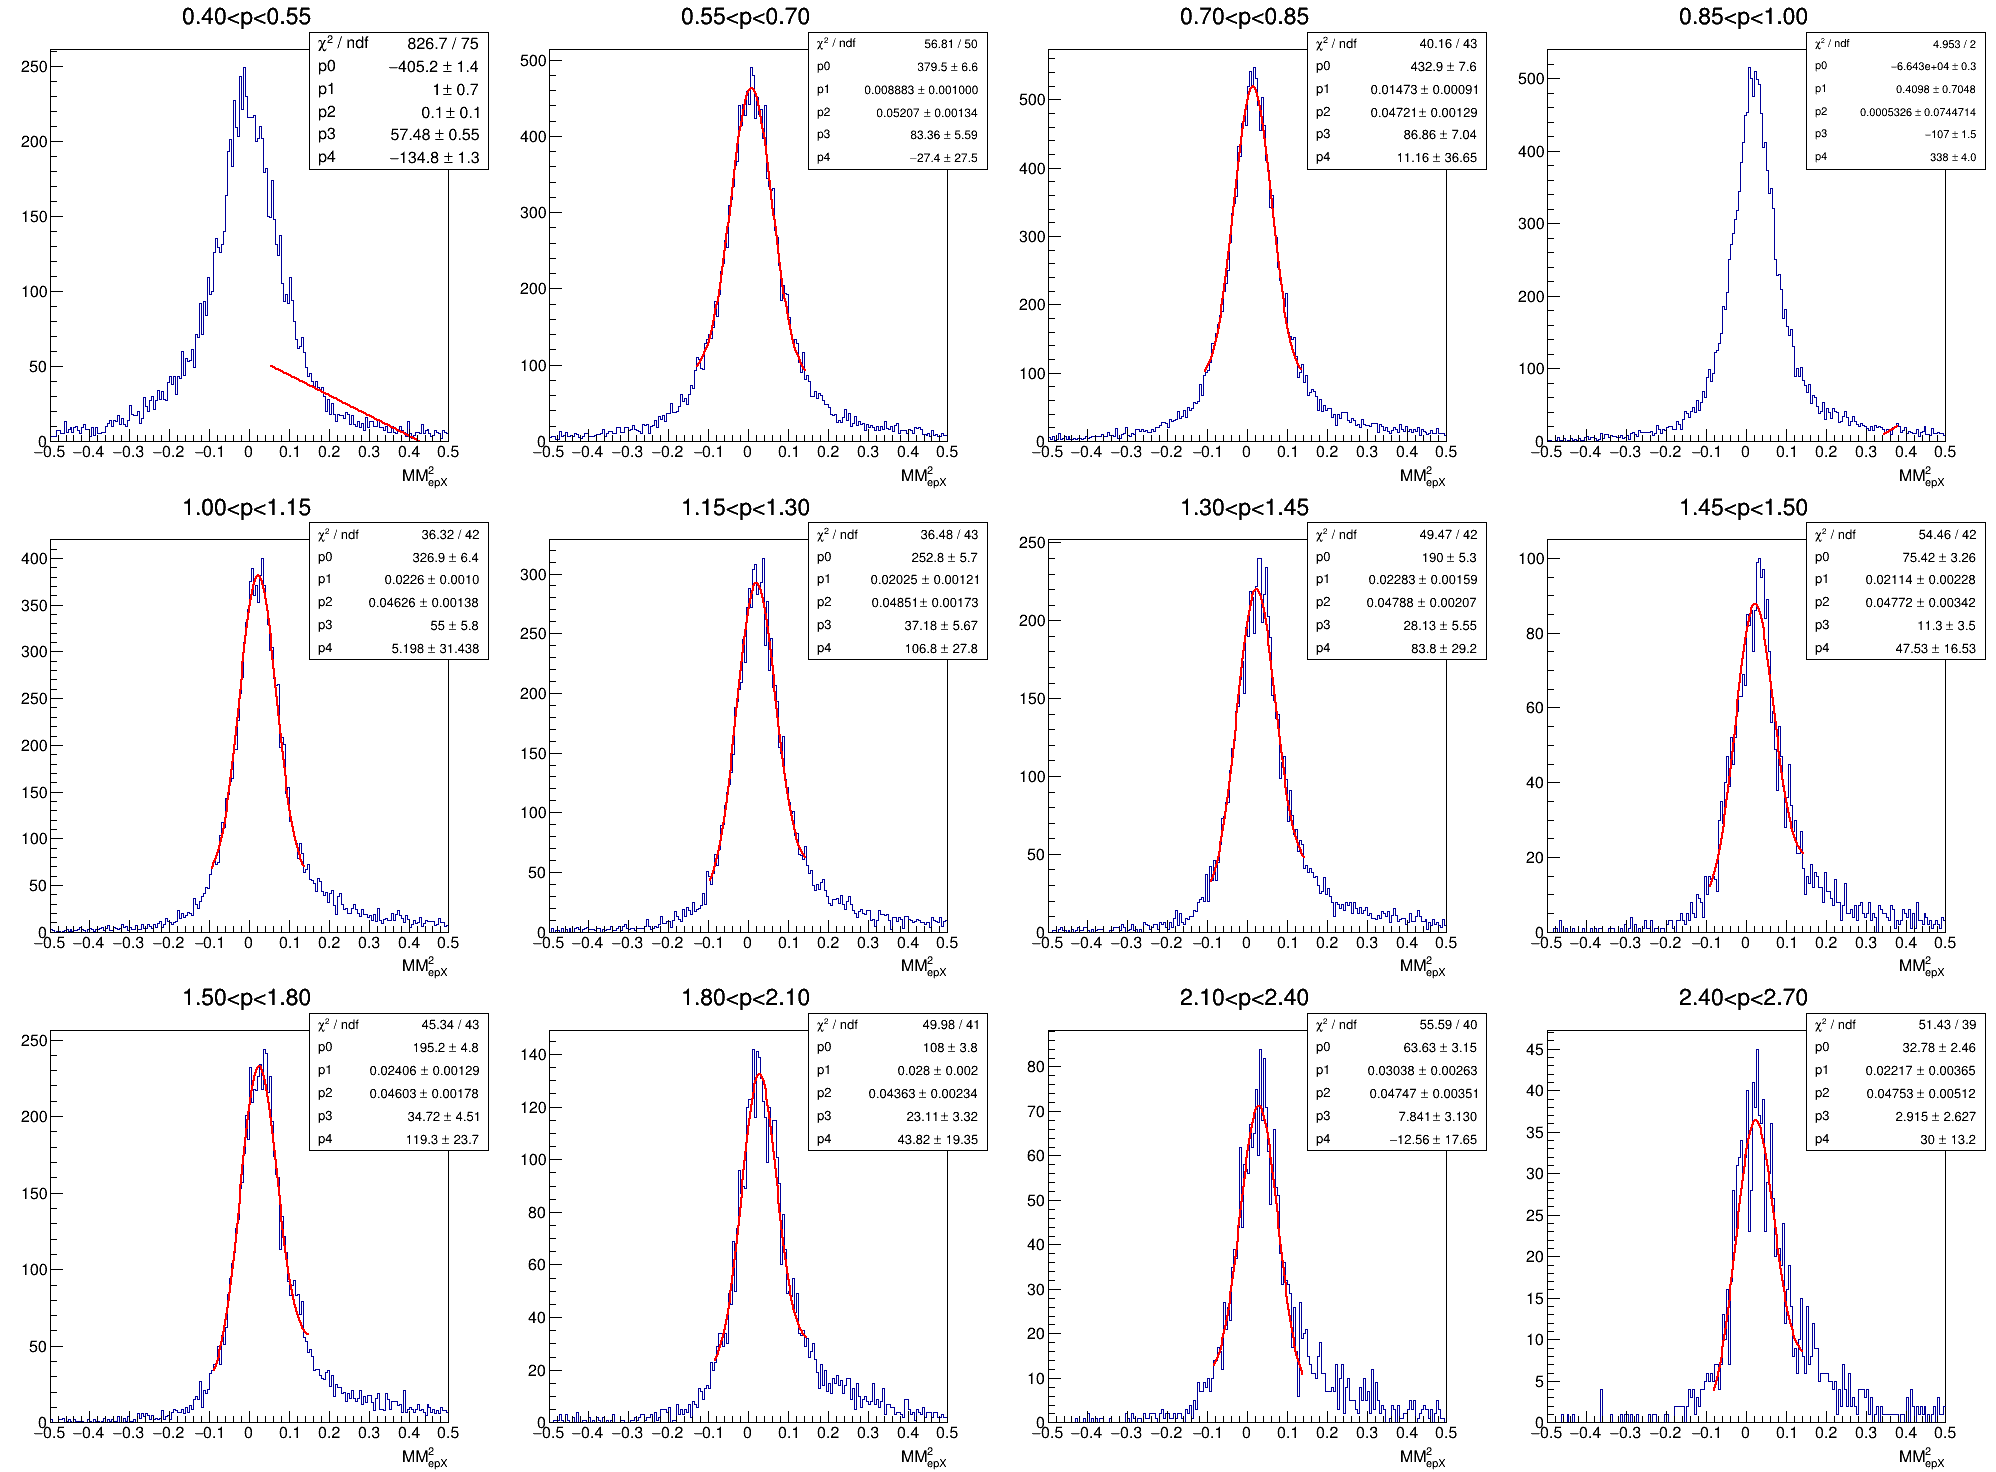

In [9]:
c2 = ROOT.TCanvas("c2","c2",2000,1500)
c2.Divide(4,3,0.0001,0.0001)
c2.Draw()
ROOT.gStyle.SetOptFit(1)
for ii in range(12):
    c2.cd(ii+1)
    hmm1pp.hys[ii].Draw()

In [10]:
fout = ROOT.TFile("graphs.root","update")
hmm0pp.gr.Write(f"MM.{conf}.nocorrection")
hmm1pp.gr.Write(f"MM.{conf}.elosscorrected")
[hmm1pps[isec-1].gr.Write(f"MM.{conf}.elosscorrected.{isec}") for isec in range(1,7)]
fout.Close()

In [11]:
leg = ROOT.TLegend(0.75,0.9,1,1)
leg.AddEntry(grinb0, "inbending", "LP")
leg.AddEntry(groutb0, "outbending", "LP")

c1 = ROOT.TCanvas("c1","c1",2500,500)
c1.Divide(6,1,0.0001,0.0001)
c1.Draw()

fin = ROOT.TFile("graphs.root")

for isec in range(1,7):
    pad=c1.cd(isec)
    pad.SetGrid()
    grinb0 = fin.Get(f"MM.inb.qa.elosscorrected.{isec}")
    groutb0 = fin.Get(f"MM.outb.qa.elosscorrected.{isec}")

    pad.SetMargin(0.1,0.001,0.1,0.06)
    pad.DrawFrame(0,-0.12,4,0.1).SetTitle(f"proton sector {isec};proton momentum;MM^{{2}}_{{epX}}")
    leg.Draw()
    grinb0.Draw("P")
    grinb0.SetMarkerColor(1)
    groutb0.Draw("P")
    groutb0.SetMarkerColor(2)
c1.Print("MM2epX.elosscorrected.pdf")

NameError: name 'grinb0' is not defined